# Exploração de Dados - Segmentação de Exudatos e Hemorragias

Este notebook realiza análise exploratória do dataset IDRiD para segmentação de:
- **Exudatos** (Hard e Soft combinados)
- **Hemorragias**

## Estrutura do Notebook
1. Carregar configurações e dados
2. Análise da distribuição das classes
3. Visualização de exemplos
4. Análise de propriedades das imagens

In [5]:
import sys
import os

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [6]:
from configs.config import Config
from data_factory.data_factory import DataFactory
from data_factory.ROP_dataset import ROPDataset
from utils.utils import set_seed

# Criar configuração
config = Config()

# Definir seed para reprodutibilidade
set_seed(config.random_state)

# Criar DataFactory
data_factory = DataFactory(config)

print(f"Dataset root: {config.dataset_root}")
print(f"Classes: {config.classes}")
print(f"Image size: {config.image_size}")
print(f"Apply CLAHE: {config.apply_clahe}")

Dataset root: /home/lucas/mestrado/tapi_inrid/A. Segmentation
Classes: ['exudates', 'haemorrhages']
Image size: (512, 512)
Apply CLAHE: True


In [7]:
# Criar DataFrames com metadados
train_df, test_df = data_factory.create_metadata_dataframe()

print(f"Training set: {len(train_df)} imagens")
print(f"Test set: {len(test_df)} imagens")
print(f"\nTotal: {len(train_df) + len(test_df)} imagens")

# Visualizar primeiras linhas
print("\n--- Primeiras linhas do DataFrame de treino ---")
display(train_df.head())

Creating metadata DataFrames...
Train set: 54 images
Test set: 27 images
Training set: 54 imagens
Test set: 27 imagens

Total: 81 imagens

--- Primeiras linhas do DataFrame de treino ---


image_path image_name  split  \
0  /home/lucas/mestrado/tapi_inrid/A. Segmentatio...   IDRiD_01  train   
1  /home/lucas/mestrado/tapi_inrid/A. Segmentatio...   IDRiD_02  train   
2  /home/lucas/mestrado/tapi_inrid/A. Segmentatio...   IDRiD_03  train   
3  /home/lucas/mestrado/tapi_inrid/A. Segmentatio...   IDRiD_04  train   
4  /home/lucas/mestrado/tapi_inrid/A. Segmentatio...   IDRiD_05  train   

  patient_id                                mask_exudates_paths  has_exudates  \
0         01  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...          True   
1         02  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...          True   
2         03  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...          True   
3         04  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...          True   
4         05  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...          True   

                             mask_haemorrhages_paths  has_haemorrhages  
0  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...              True  
1  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...              True  
2  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...              True  
3  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...              True  
4  [/home/lucas/mestrado/tapi_inrid/A. Segmentati...              True

=== Distribuição - Training Set ===


count  percentage
exudates       54.0  100.000000
haemorrhages   53.0   98.148148


=== Distribuição - Test Set ===


count  percentage
exudates       27.0       100.0
haemorrhages   27.0       100.0

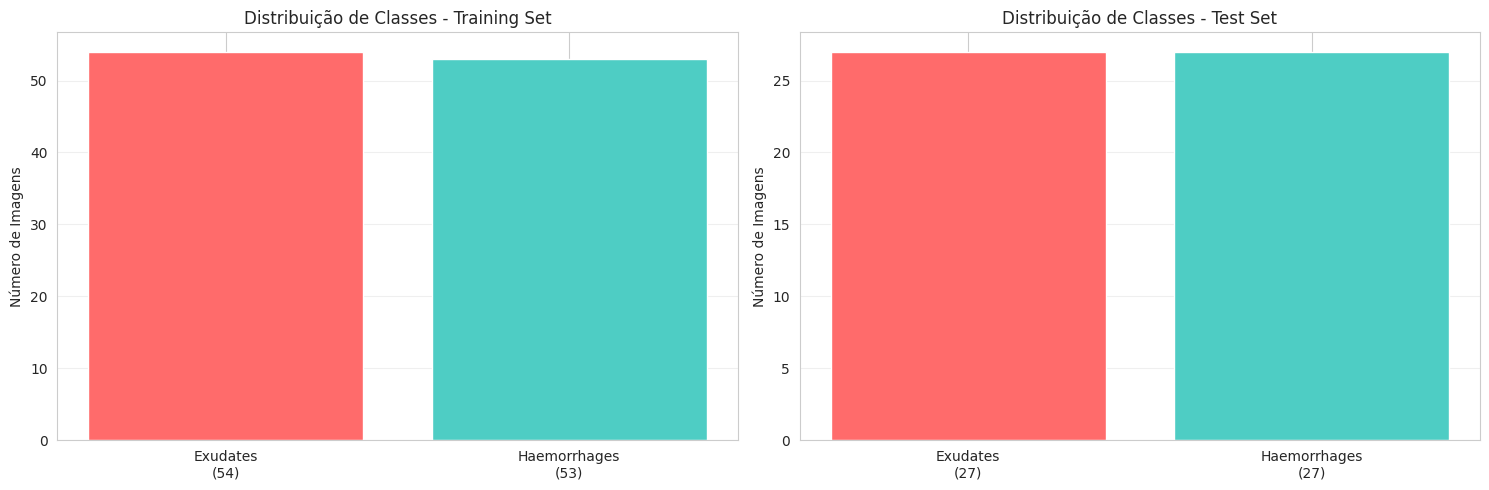

In [8]:
# Obter distribuição das classes
train_dist = data_factory.get_class_distribution(train_df)
test_dist = data_factory.get_class_distribution(test_df)

print("=== Distribuição - Training Set ===")
display(train_dist)

print("\n=== Distribuição - Test Set ===")
display(test_dist)

# Visualizar distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
train_counts = train_dist['count'].values
train_labels = [f"{cls.capitalize()}\n({int(cnt)})" for cls, cnt in zip(train_dist.index, train_counts)]
axes[0].bar(range(len(train_counts)), train_counts, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_xticks(range(len(train_counts)))
axes[0].set_xticklabels(train_labels)
axes[0].set_ylabel('Número de Imagens')
axes[0].set_title('Distribuição de Classes - Training Set')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_counts = test_dist['count'].values
test_labels = [f"{cls.capitalize()}\n({int(cnt)})" for cls, cnt in zip(test_dist.index, test_counts)]
axes[1].bar(range(len(test_counts)), test_counts, color=['#FF6B6B', '#4ECDC4'])
axes[1].set_xticks(range(len(test_counts)))
axes[1].set_xticklabels(test_labels)
axes[1].set_ylabel('Número de Imagens')
axes[1].set_title('Distribuição de Classes - Test Set')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Visualizando amostras: [19 49 48]


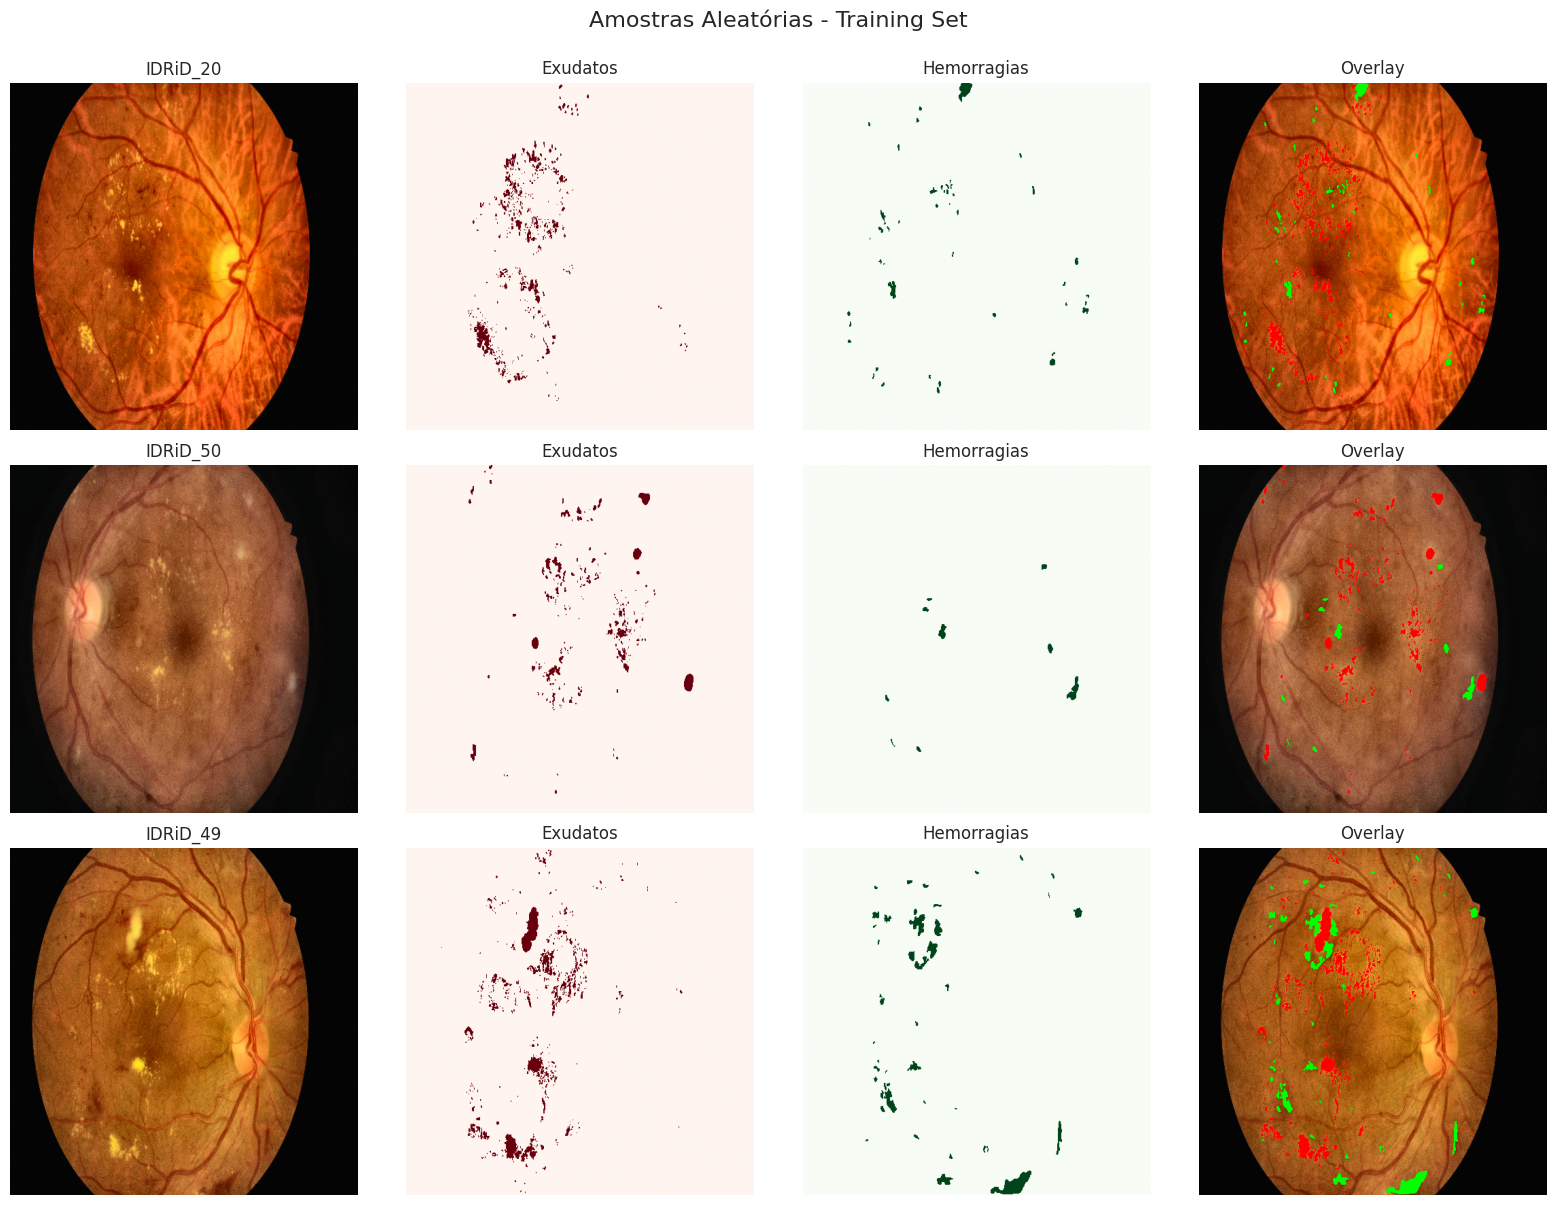

In [9]:
# Criar dataset para visualização (sem transforms para ver imagens originais)
import albumentations as A

simple_transform = A.Compose([
    A.Resize(512, 512),
])

train_dataset = ROPDataset(
    dataframe=train_df,
    config=config,
    is_train=False,  # Sem augmentation
    transform=None   # Usar default sem normalização por enquanto
)

# Função auxiliar para visualizar amostras
def visualize_samples(dataset, indices, title="Amostras"):
    """Visualiza amostras do dataset."""
    n_samples = len(indices)
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample['image']
        mask = sample['mask']
        name = sample['image_name']
        
        # Converter tensor para numpy se necessário
        if hasattr(image, 'numpy'):
            image = image.permute(1, 2, 0).numpy()
        if hasattr(mask, 'numpy'):
            mask = mask.numpy()
        
        # Denormalizar imagem se estiver normalizada
        if image.min() < 0:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean
            image = np.clip(image, 0, 1)
        
        # Original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"{name}")
        axes[i, 0].axis('off')
        
        # Exudates mask
        axes[i, 1].imshow(mask[0], cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f"Exudatos")
        axes[i, 1].axis('off')
        
        # Haemorrhages mask
        axes[i, 2].imshow(mask[1], cmap='Greens', vmin=0, vmax=1)
        axes[i, 2].set_title(f"Hemorragias")
        axes[i, 2].axis('off')
        
        # Combined overlay
        overlay = image.copy()
        
        # Criar máscaras booleanas com dimensões corretas
        exudate_mask = mask[0] > 0.5
        haemorrhage_mask = mask[1] > 0.5
        
        # Exudates in red
        overlay[exudate_mask] = [1, 0, 0]
        # Haemorrhages in green
        overlay[haemorrhage_mask] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f"Overlay")
        axes[i, 3].axis('off')
    
    plt.suptitle(title, fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

# Visualizar algumas amostras aleatórias
np.random.seed(42)
random_indices = np.random.choice(len(train_dataset), size=3, replace=False)

print(f"Visualizando amostras: {random_indices}")
visualize_samples(train_dataset, random_indices, title="Amostras Aleatórias - Training Set")

In [10]:
# DEBUG: Verificar o que está sendo carregado
import torch

sample_idx = 19
row = train_df.iloc[sample_idx]

print(f"Imagem: {row['image_name']}")
print(f"\nPath da imagem: {row['image_path']}")
print(f"\nPaths das máscaras:")
for col in train_df.columns:
    if 'mask_' in col and '_paths' in col:
        print(f"  {col}: {row[col]}")
        
# Carregar uma amostra do dataset
sample = train_dataset[sample_idx]
print(f"\nShape da imagem: {sample['image'].shape}")
print(f"Shape da máscara: {sample['mask'].shape}")
print(f"Min/Max da máscara: {sample['mask'].min()}/{sample['mask'].max()}")
print(f"Valores únicos na máscara[0] (exudates): {torch.unique(sample['mask'][0])}")
print(f"Valores únicos na máscara[1] (haemorrhages): {torch.unique(sample['mask'][1])}")

# Carregar máscara diretamente do arquivo para verificar
import cv2
mask_path = row['mask_exudates_paths'][0]
print(f"\n=== Carregando máscara diretamente ===")
print(f"Path: {mask_path}")
raw_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if raw_mask is not None:
    print(f"Shape: {raw_mask.shape}")
    print(f"Dtype: {raw_mask.dtype}")
    print(f"Min/Max: {raw_mask.min()}/{raw_mask.max()}")
    print(f"Valores únicos: {np.unique(raw_mask)}")
else:
    print("Erro ao carregar máscara!")

Imagem: IDRiD_20

Path da imagem: /home/lucas/mestrado/tapi_inrid/A. Segmentation/1. Original Images/a. Training Set/IDRiD_20.jpg

Paths das máscaras:
  mask_exudates_paths: ['/home/lucas/mestrado/tapi_inrid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates/IDRiD_20_EX.tif']
  mask_haemorrhages_paths: ['/home/lucas/mestrado/tapi_inrid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages/IDRiD_20_HE.tif']

Shape da imagem: torch.Size([3, 512, 512])
Shape da máscara: torch.Size([2, 512, 512])
Min/Max da máscara: 0.0/1.0
Valores únicos na máscara[0] (exudates): tensor([0., 1.])
Valores únicos na máscara[1] (haemorrhages): tensor([0., 1.])

=== Carregando máscara diretamente ===
Path: /home/lucas/mestrado/tapi_inrid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates/IDRiD_20_EX.tif
Shape: (2848, 4288)
Dtype: uint8
Min/Max: 0/76
Valores únicos: [ 0 76]
Valores únicos na máscara[1] (haemorrhages): tens

In [11]:
# Verificar valores de várias máscaras
print("Verificando valores de algumas máscaras...\n")

for idx in [0, 5, 10, 19, 48]:
    row = train_df.iloc[idx]
    print(f"--- {row['image_name']} ---")
    
    # Exudates
    if isinstance(row['mask_exudates_paths'], list) and len(row['mask_exudates_paths']) > 0:
        mask_path = row['mask_exudates_paths'][0]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            print(f"  Exudates: min={mask.min()}, max={mask.max()}, unique={np.unique(mask)}")
    else:
        print(f"  Exudates: sem máscara")
    
    # Haemorrhages
    if isinstance(row['mask_haemorrhages_paths'], list) and len(row['mask_haemorrhages_paths']) > 0:
        mask_path = row['mask_haemorrhages_paths'][0]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            print(f"  Haemorrhages: min={mask.min()}, max={mask.max()}, unique={np.unique(mask)}")
    else:
        print(f"  Haemorrhages: sem máscara")
    print()

Verificando valores de algumas máscaras...

--- IDRiD_01 ---


  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_06 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_11 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_11 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_20 ---
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_20 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_49 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

--- IDRiD_49 ---
  Exudates: min=0, max=76, unique=[ 0 76]
  Exudates: min=0, max=76, unique=[ 0 76]
  Haemorrhages: min=0, max=76, unique=[ 0 76]

  Haemorrhages: min=0, max=76, unique=[ 0 76]



In [12]:
# Recarregar o módulo ROPDataset e recriar o dataset
import importlib
import data_factory.ROP_dataset
importlib.reload(data_factory.ROP_dataset)
from data_factory.ROP_dataset import ROPDataset

# Recriar dataset
train_dataset = ROPDataset(
    dataframe=train_df,
    config=config,
    is_train=False,  # Sem augmentation
    transform=None   # Usar default sem normalização por enquanto
)

# Testar com a primeira amostra
sample = train_dataset[19]
print(f"Shape da imagem: {sample['image'].shape}")
print(f"Shape da máscara: {sample['mask'].shape}")
print(f"Min/Max da máscara: {sample['mask'].min():.3f}/{sample['mask'].max():.3f}")
print(f"Valores únicos na máscara[0] (exudates): {torch.unique(sample['mask'][0])}")
print(f"Valores únicos na máscara[1] (haemorrhages): {torch.unique(sample['mask'][1])}")
print(f"Pixels positivos exudates: {(sample['mask'][0] > 0).sum()}")
print(f"Pixels positivos haemorrhages: {(sample['mask'][1] > 0).sum()}")

Shape da imagem: torch.Size([3, 512, 512])
Shape da máscara: torch.Size([2, 512, 512])
Min/Max da máscara: 0.000/1.000
Valores únicos na máscara[0] (exudates): tensor([0., 1.])
Valores únicos na máscara[1] (haemorrhages): tensor([0., 1.])
Pixels positivos exudates: 3948
Pixels positivos haemorrhages: 1437


In [13]:
# Debug: verificar dimensões
sample = train_dataset[0]
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")
print(f"Image type: {type(sample['image'])}")
print(f"Mask type: {type(sample['mask'])}")

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512])
Image type: <class 'torch.Tensor'>
Mask type: <class 'torch.Tensor'>


In [14]:
# Recarregar módulo
import importlib
import data_factory.ROP_dataset
importlib.reload(data_factory.ROP_dataset)
from data_factory.ROP_dataset import ROPDataset

# Recriar dataset
train_dataset = ROPDataset(
    dataframe=train_df,
    config=config,
    is_train=False,
    transform=None
)

# Verificar novamente
sample = train_dataset[0]
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512])


Total de imagens com exudatos: 54


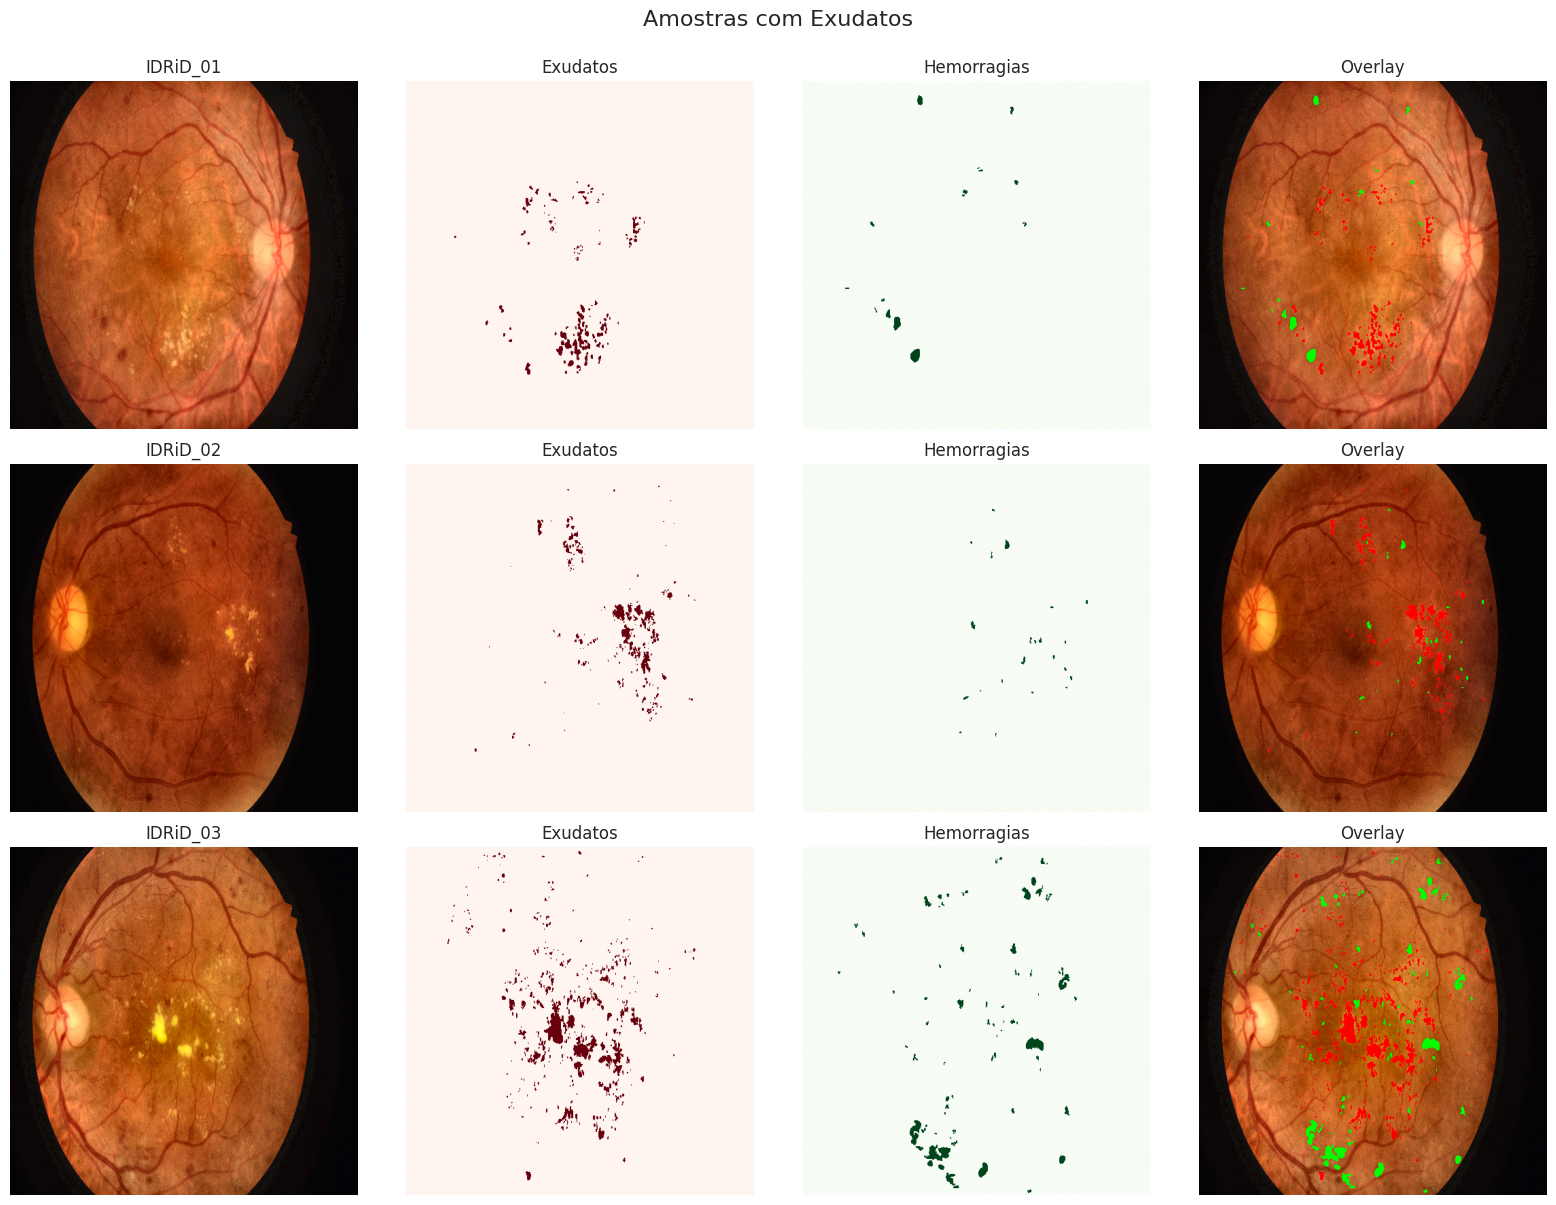

In [15]:
# Encontrar imagens com exudatos
exudate_indices = train_df[train_df['has_exudates'] == True].index.tolist()

print(f"Total de imagens com exudatos: {len(exudate_indices)}")

if len(exudate_indices) > 0:
    # Selecionar algumas amostras
    sample_indices = exudate_indices[:3] if len(exudate_indices) >= 3 else exudate_indices
    visualize_samples(train_dataset, sample_indices, title="Amostras com Exudatos")

Total de imagens com hemorragias: 53


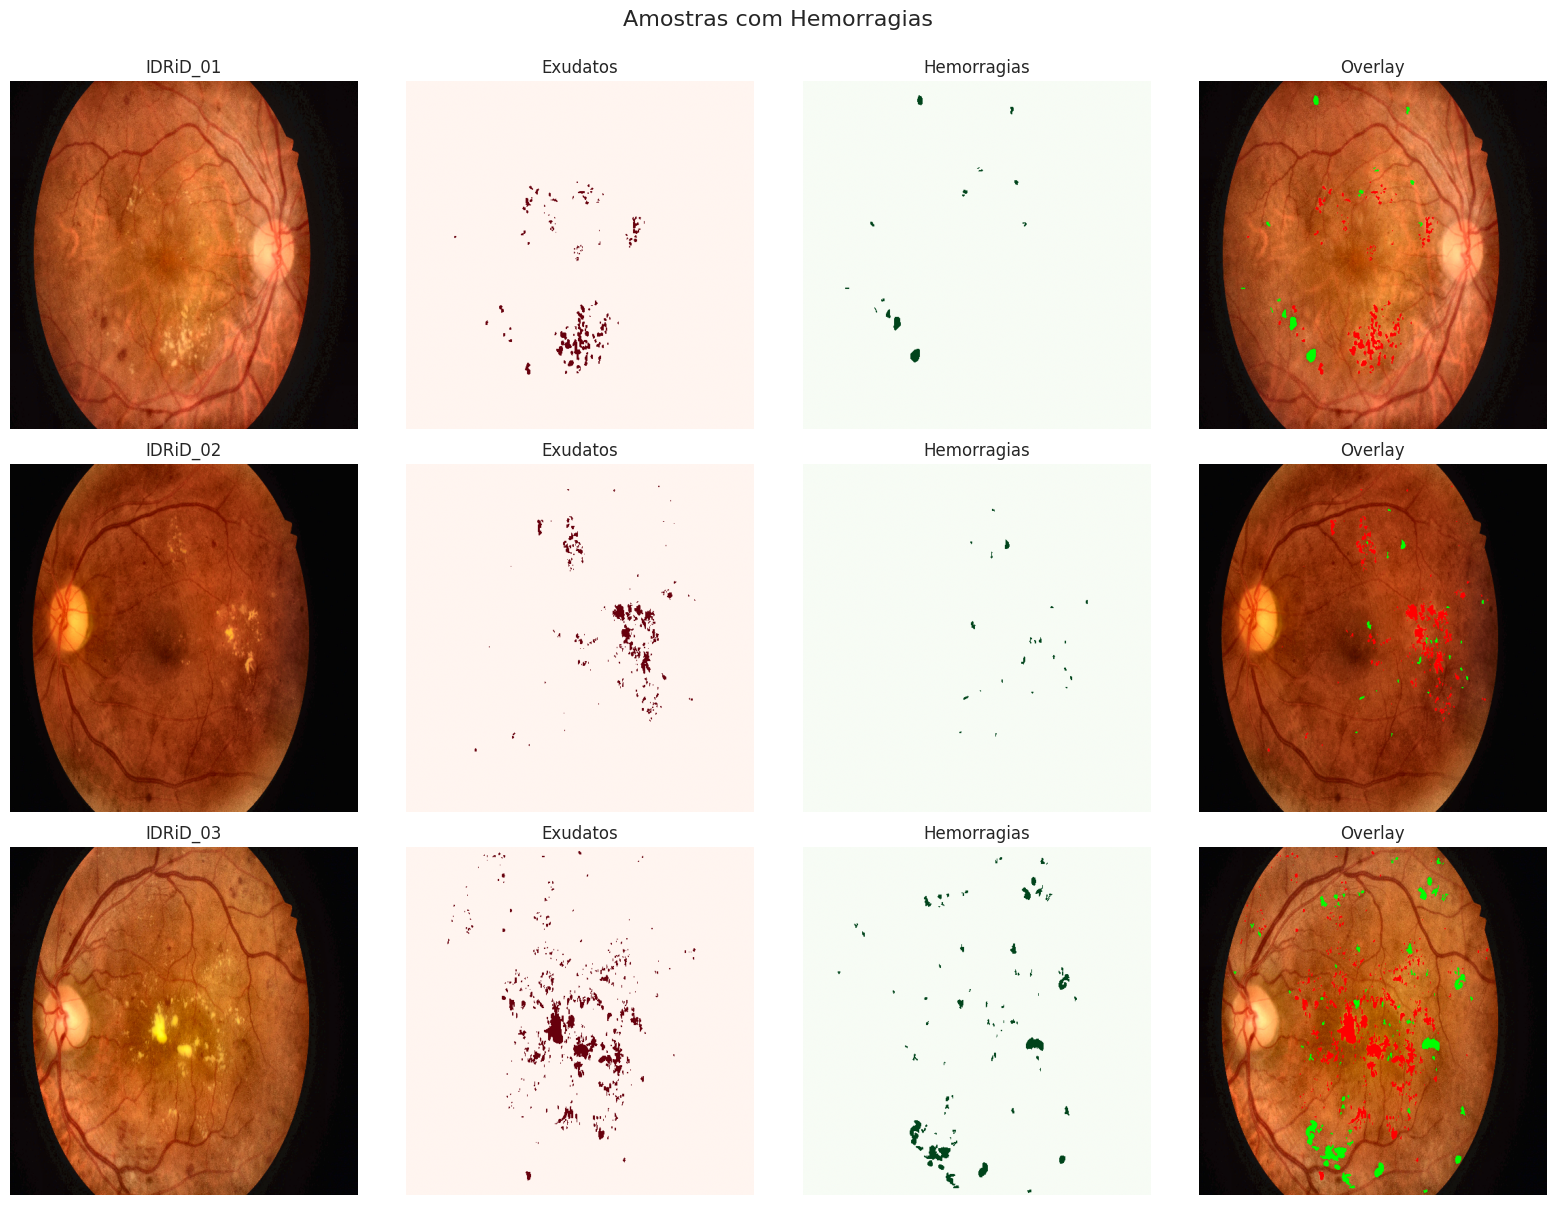

In [16]:
# Encontrar imagens com hemorragias
haemorrhage_indices = train_df[train_df['has_haemorrhages'] == True].index.tolist()

print(f"Total de imagens com hemorragias: {len(haemorrhage_indices)}")

if len(haemorrhage_indices) > 0:
    # Selecionar algumas amostras
    sample_indices = haemorrhage_indices[:3] if len(haemorrhage_indices) >= 3 else haemorrhage_indices
    visualize_samples(train_dataset, sample_indices, title="Amostras com Hemorragias")

In [17]:
# Analisar dimensões das imagens
image_sizes = []

for idx in range(min(20, len(train_df))):  # Verificar primeiras 20 imagens
    img_path = train_df.iloc[idx]['image_path']
    img = cv2.imread(img_path)
    if img is not None:
        image_sizes.append(img.shape[:2])

image_sizes = np.array(image_sizes)

print("=== Análise de Dimensões das Imagens ===")
print(f"Dimensões únicas encontradas:")
unique_sizes = np.unique(image_sizes, axis=0)
for size in unique_sizes:
    count = np.sum((image_sizes == size).all(axis=1))
    print(f"  {size[0]}x{size[1]}: {count} imagens")

print(f"\nTamanho configurado para treinamento: {config.image_size}")

=== Análise de Dimensões das Imagens ===
Dimensões únicas encontradas:
  2848x4288: 20 imagens

Tamanho configurado para treinamento: (512, 512)


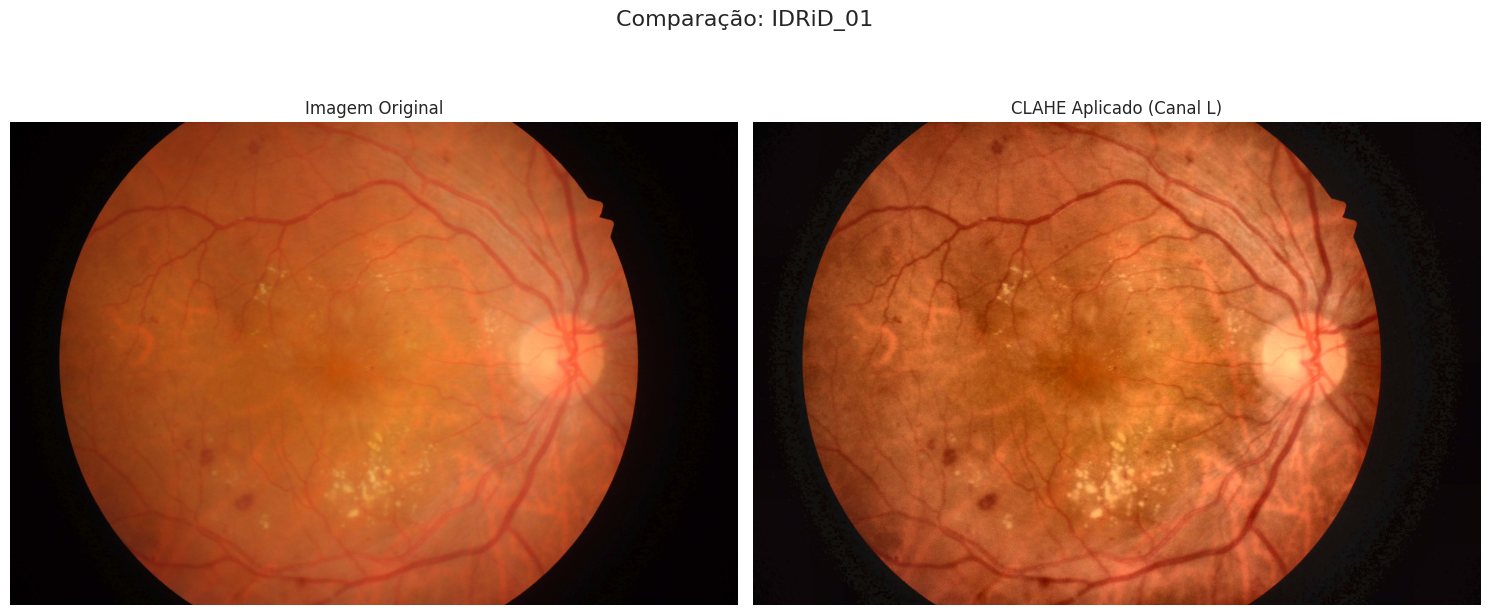

CLAHE (Contrast Limited Adaptive Histogram Equalization):
- Melhora o contraste local da imagem
- Aplicado no canal L (luminosidade) do espaço de cor LAB
- Clip Limit: 2.0
- Tile Grid Size: (8, 8)


In [18]:
# Comparar imagem original vs CLAHE
def apply_clahe_manual(image):
    """Aplicar CLAHE manualmente para visualização."""
    # Converter RGB para LAB
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Split channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(
        clipLimit=config.clahe_clip_limit,
        tileGridSize=config.clahe_tile_grid_size
    )
    l_clahe = clahe.apply(l)
    
    # Merge channels
    lab_clahe = cv2.merge([l_clahe, a, b])
    
    # Convert back to RGB
    image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    return image_clahe

# Carregar uma imagem de exemplo
sample_idx = 0
img_path = train_df.iloc[sample_idx]['image_path']
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Aplicar CLAHE
image_clahe = apply_clahe_manual(image_rgb)

# Visualizar comparação
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image_rgb)
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(image_clahe)
axes[1].set_title('CLAHE Aplicado (Canal L)')
axes[1].axis('off')

plt.suptitle(f"Comparação: {train_df.iloc[sample_idx]['image_name']}", fontsize=16)
plt.tight_layout()
plt.show()

print("CLAHE (Contrast Limited Adaptive Histogram Equalization):")
print("- Melhora o contraste local da imagem")
print("- Aplicado no canal L (luminosidade) do espaço de cor LAB")
print(f"- Clip Limit: {config.clahe_clip_limit}")
print(f"- Tile Grid Size: {config.clahe_tile_grid_size}")

=== Distribuição por Paciente ===
Training set: 54 pacientes únicos
Test set: 27 pacientes únicos


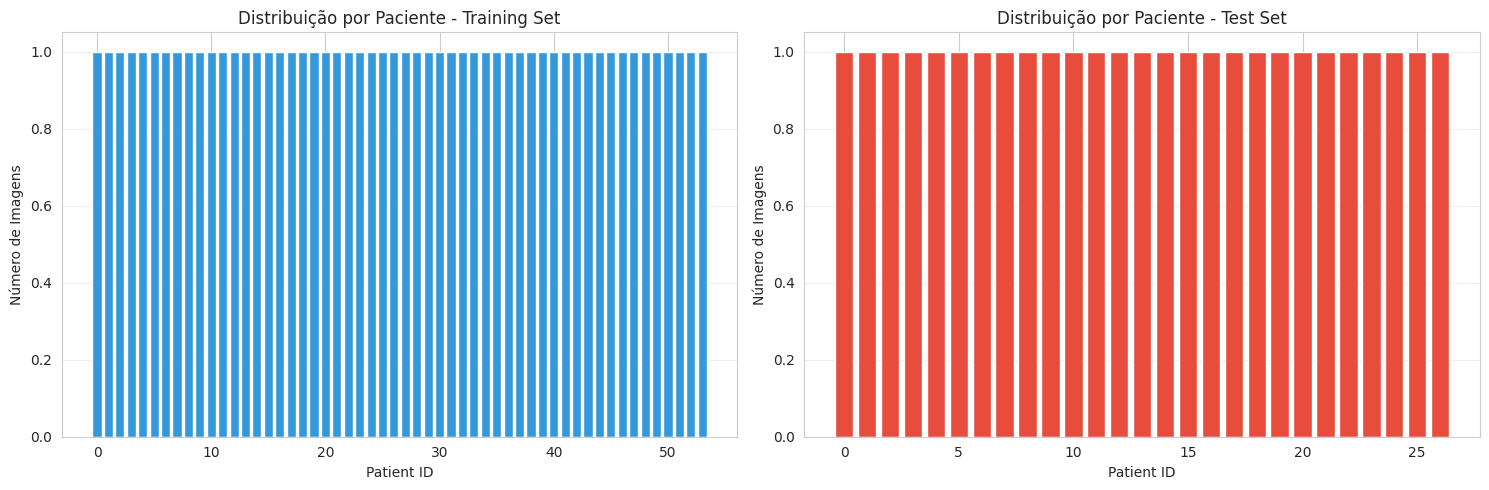


Imagens por paciente (training): count    54.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: count, dtype: float64


In [19]:
# Analisar distribuição por paciente
train_patients = train_df['patient_id'].nunique()
test_patients = test_df['patient_id'].nunique()

print(f"=== Distribuição por Paciente ===")
print(f"Training set: {train_patients} pacientes únicos")
print(f"Test set: {test_patients} pacientes únicos")

# Criar visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set - contagem por paciente
train_patient_counts = train_df['patient_id'].value_counts().sort_index()
axes[0].bar(range(len(train_patient_counts)), train_patient_counts.values, color='#3498db')
axes[0].set_xlabel('Patient ID')
axes[0].set_ylabel('Número de Imagens')
axes[0].set_title('Distribuição por Paciente - Training Set')
axes[0].grid(axis='y', alpha=0.3)

# Test set - contagem por paciente
test_patient_counts = test_df['patient_id'].value_counts().sort_index()
axes[1].bar(range(len(test_patient_counts)), test_patient_counts.values, color='#e74c3c')
axes[1].set_xlabel('Patient ID')
axes[1].set_ylabel('Número de Imagens')
axes[1].set_title('Distribuição por Paciente - Test Set')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImagens por paciente (training): {train_patient_counts.describe()}")

## 11. Resumo e Conclusões

Este notebook apresentou uma análise exploratória completa do dataset IDRiD para segmentação de:
- **Exudatos** (Hard e Soft combinados)
- **Hemorragias**

### Principais Observações:
1. **Dataset estruturado** com separação clara entre training/test sets
2. **Múltiplas máscaras** para exudatos (hard e soft são combinadas)
3. **Pré-processamento CLAHE** melhora contraste local
4. **GroupKFold** será usado para evitar data leakage por paciente
5. **Multi-label segmentation** permite lesões coexistentes

### Próximos Passos:
- Executar `main.py` para treinar o modelo
- Avaliar performance com métricas Dice e IoU
- Analisar predições no conjunto de teste

## 12. Análise de Tamanho de Imagens para Patch-Based Segmentation

Vamos verificar os tamanhos originais das imagens e determinar tamanhos de patches adequados para segmentação.

In [22]:
# Analisar tamanhos originais de TODAS as imagens (train + test)
all_image_sizes = []
image_names = []

print("=== Analisando tamanhos das imagens originais ===\n")

# Training set
print("Training set:")
for idx in range(len(train_df)):
    img_path = train_df.iloc[idx]['image_path']
    img_name = train_df.iloc[idx]['image_name']
    img = cv2.imread(img_path)
    if img is not None:
        all_image_sizes.append(img.shape[:2])
        image_names.append(img_name)
        if idx < 5:  # Mostrar primeiras 5
            print(f"  {img_name}: {img.shape[1]}x{img.shape[0]} (W x H)")

print(f"\n  Total: {len(train_df)} imagens")

# Test set
print("\nTest set:")
for idx in range(len(test_df)):
    img_path = test_df.iloc[idx]['image_path']
    img_name = test_df.iloc[idx]['image_name']
    img = cv2.imread(img_path)
    if img is not None:
        all_image_sizes.append(img.shape[:2])
        image_names.append(img_name)
        if idx < 5:  # Mostrar primeiras 5
            print(f"  {img_name}: {img.shape[1]}x{img.shape[0]} (W x H)")

print(f"\n  Total: {len(test_df)} imagens")

# Converter para array numpy
all_image_sizes = np.array(all_image_sizes)

print(f"\n{'='*60}")
print("=== Resumo dos Tamanhos ===")
print(f"{'='*60}")
print(f"\nTotal de imagens analisadas: {len(all_image_sizes)}")
print(f"\nDimensões únicas encontradas:")
unique_sizes = np.unique(all_image_sizes, axis=0)
for size in unique_sizes:
    count = np.sum((all_image_sizes == size).all(axis=1))
    print(f"  {size[1]}x{size[0]} (W x H): {count} imagens ({100*count/len(all_image_sizes):.1f}%)")

print(f"\nEstatísticas:")
print(f"  Altura (H): min={all_image_sizes[:, 0].min()}, max={all_image_sizes[:, 0].max()}, mean={all_image_sizes[:, 0].mean():.1f}")
print(f"  Largura (W): min={all_image_sizes[:, 1].min()}, max={all_image_sizes[:, 1].max()}, mean={all_image_sizes[:, 1].mean():.1f}")

=== Analisando tamanhos das imagens originais ===

Training set:
  IDRiD_01: 4288x2848 (W x H)
  IDRiD_02: 4288x2848 (W x H)
  IDRiD_03: 4288x2848 (W x H)
  IDRiD_04: 4288x2848 (W x H)
  IDRiD_05: 4288x2848 (W x H)

  Total: 54 imagens

Test set:
  IDRiD_55: 4288x2848 (W x H)
  IDRiD_56: 4288x2848 (W x H)
  IDRiD_57: 4288x2848 (W x H)
  IDRiD_58: 4288x2848 (W x H)
  IDRiD_59: 4288x2848 (W x H)

  Total: 54 imagens

Test set:
  IDRiD_55: 4288x2848 (W x H)
  IDRiD_56: 4288x2848 (W x H)
  IDRiD_57: 4288x2848 (W x H)
  IDRiD_58: 4288x2848 (W x H)
  IDRiD_59: 4288x2848 (W x H)

  Total: 27 imagens

=== Resumo dos Tamanhos ===

Total de imagens analisadas: 81

Dimensões únicas encontradas:
  4288x2848 (W x H): 81 imagens (100.0%)

Estatísticas:
  Altura (H): min=2848, max=2848, mean=2848.0
  Largura (W): min=4288, max=4288, mean=4288.0

  Total: 27 imagens

=== Resumo dos Tamanhos ===

Total de imagens analisadas: 81

Dimensões únicas encontradas:
  4288x2848 (W x H): 81 imagens (100.0%)

Es

In [23]:
# Análise de possíveis tamanhos de patches
print("="*60)
print("=== Análise de Tamanhos de Patches Viáveis ===")
print("="*60)

# Assumir que todas as imagens têm o mesmo tamanho (baseado na análise anterior)
img_height, img_width = unique_sizes[0]

print(f"\nDimensões da imagem: {img_width}x{img_height} (W x H)")
print(f"\nTamanhos de patches comuns e sua divisibilidade:")
print("-" * 60)

# Tamanhos de patch comuns
patch_sizes = [128, 256, 384, 512, 640, 768, 896, 1024]

for patch_size in patch_sizes:
    # Calcular quantos patches cabem em cada dimensão
    patches_w = img_width / patch_size
    patches_h = img_height / patch_size
    
    # Verificar se divide exatamente
    exact_fit_w = (img_width % patch_size == 0)
    exact_fit_h = (img_height % patch_size == 0)
    
    total_patches = int(np.ceil(patches_w) * np.ceil(patches_h))
    
    fit_status = ""
    if exact_fit_w and exact_fit_h:
        fit_status = "✓ Divisão exata"
    else:
        fit_status = "⚠ Requer padding ou overlap"
    
    print(f"\nPatch {patch_size}x{patch_size}:")
    print(f"  Largura:  {patches_w:.2f} patches ({int(np.ceil(patches_w))} com padding)")
    print(f"  Altura:   {patches_h:.2f} patches ({int(np.ceil(patches_h))} com padding)")
    print(f"  Total:    {total_patches} patches")
    print(f"  Status:   {fit_status}")
    
    # Calcular overlap necessário para divisão exata
    if not (exact_fit_w and exact_fit_h):
        # Calcular stride para divisão mais equilibrada
        stride_w = img_width // int(np.ceil(patches_w))
        stride_h = img_height // int(np.ceil(patches_h))
        overlap_w = patch_size - stride_w if stride_w < patch_size else 0
        overlap_h = patch_size - stride_h if stride_h < patch_size else 0
        if overlap_w > 0 or overlap_h > 0:
            print(f"  Overlap sugerido: {overlap_w}px (W), {overlap_h}px (H)")

=== Análise de Tamanhos de Patches Viáveis ===

Dimensões da imagem: 4288x2848 (W x H)

Tamanhos de patches comuns e sua divisibilidade:
------------------------------------------------------------

Patch 128x128:
  Largura:  33.50 patches (34 com padding)
  Altura:   22.25 patches (23 com padding)
  Total:    782 patches
  Status:   ⚠ Requer padding ou overlap
  Overlap sugerido: 2px (W), 5px (H)

Patch 256x256:
  Largura:  16.75 patches (17 com padding)
  Altura:   11.12 patches (12 com padding)
  Total:    204 patches
  Status:   ⚠ Requer padding ou overlap
  Overlap sugerido: 4px (W), 19px (H)

Patch 384x384:
  Largura:  11.17 patches (12 com padding)
  Altura:   7.42 patches (8 com padding)
  Total:    96 patches
  Status:   ⚠ Requer padding ou overlap
  Overlap sugerido: 27px (W), 28px (H)

Patch 512x512:
  Largura:  8.38 patches (9 com padding)
  Altura:   5.56 patches (6 com padding)
  Total:    54 patches
  Status:   ⚠ Requer padding ou overlap
  Overlap sugerido: 36px (W), 38

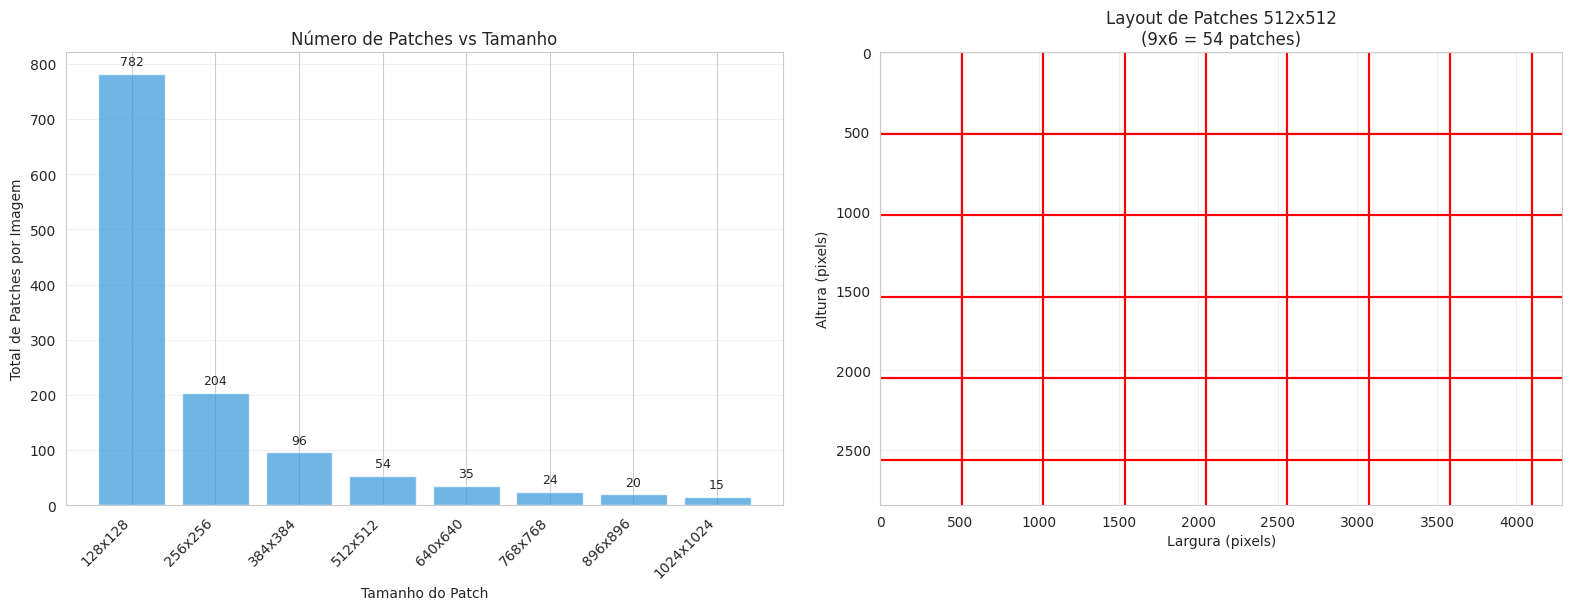


=== Recomendações para Patch-Based Segmentation ===

Dimensão original: 4288x2848 pixels

✓ Patches RECOMENDADOS:
  • 512x512: 54 patches por imagem (bom equilíbrio)
  • 640x640: 35 patches por imagem (patches maiores)
  • 768x768: 24 patches por imagem (menos patches)

⚠ Considerações:
  • Todos os tamanhos requerem padding ou overlap
  • Overlap é preferível ao padding para preservar contexto
  • Patches menores (128, 256) geram muitas amostras (pode ser lento)
  • Patches maiores (896, 1024) podem perder detalhes finos

💡 Sugestão para experimentação:
  1. Começar com 512x512 (overlap de ~40px)
  2. Testar 640x640 ou 768x768 se houver memória GPU suficiente
  3. Usar sliding window com overlap de 10-20% do tamanho do patch


In [24]:
# Visualização gráfica da comparação de patches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Total de patches por tamanho
total_patches_list = []
for patch_size in patch_sizes:
    patches_w = int(np.ceil(img_width / patch_size))
    patches_h = int(np.ceil(img_height / patch_size))
    total_patches_list.append(patches_w * patches_h)

ax1.bar(range(len(patch_sizes)), total_patches_list, color='#3498db', alpha=0.7)
ax1.set_xticks(range(len(patch_sizes)))
ax1.set_xticklabels([f"{s}x{s}" for s in patch_sizes], rotation=45, ha='right')
ax1.set_xlabel('Tamanho do Patch')
ax1.set_ylabel('Total de Patches por Imagem')
ax1.set_title('Número de Patches vs Tamanho')
ax1.grid(axis='y', alpha=0.3)

# Adicionar valores no topo das barras
for i, v in enumerate(total_patches_list):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=9)

# Gráfico 2: Layout de patches (exemplo com 512x512)
example_patch_size = 512
patches_w = int(np.ceil(img_width / example_patch_size))
patches_h = int(np.ceil(img_height / example_patch_size))

# Desenhar grid de patches
ax2.set_xlim(0, img_width)
ax2.set_ylim(0, img_height)
ax2.set_aspect('equal')

# Desenhar retângulos dos patches
for i in range(patches_w):
    for j in range(patches_h):
        x = i * example_patch_size
        y = j * example_patch_size
        rect = plt.Rectangle((x, y), example_patch_size, example_patch_size, 
                            fill=False, edgecolor='red', linewidth=1.5)
        ax2.add_patch(rect)

ax2.set_xlabel('Largura (pixels)')
ax2.set_ylabel('Altura (pixels)')
ax2.set_title(f'Layout de Patches {example_patch_size}x{example_patch_size}\n({patches_w}x{patches_h} = {patches_w*patches_h} patches)')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("=== Recomendações para Patch-Based Segmentation ===")
print("="*60)
print(f"\nDimensão original: {img_width}x{img_height} pixels")
print(f"\n✓ Patches RECOMENDADOS:")
print(f"  • 512x512: {54} patches por imagem (bom equilíbrio)")
print(f"  • 640x640: {35} patches por imagem (patches maiores)")
print(f"  • 768x768: {24} patches por imagem (menos patches)")
print(f"\n⚠ Considerações:")
print(f"  • Todos os tamanhos requerem padding ou overlap")
print(f"  • Overlap é preferível ao padding para preservar contexto")
print(f"  • Patches menores (128, 256) geram muitas amostras (pode ser lento)")
print(f"  • Patches maiores (896, 1024) podem perder detalhes finos")
print(f"\n💡 Sugestão para experimentação:")
print(f"  1. Começar com 512x512 (overlap de ~40px)")
print(f"  2. Testar 640x640 ou 768x768 se houver memória GPU suficiente")
print(f"  3. Usar sliding window com overlap de 10-20% do tamanho do patch")

Imagem: IDRiD_01
Dimensões: 4288x2848 (W x H)
Grid de patches: 9x6 = 54 patches


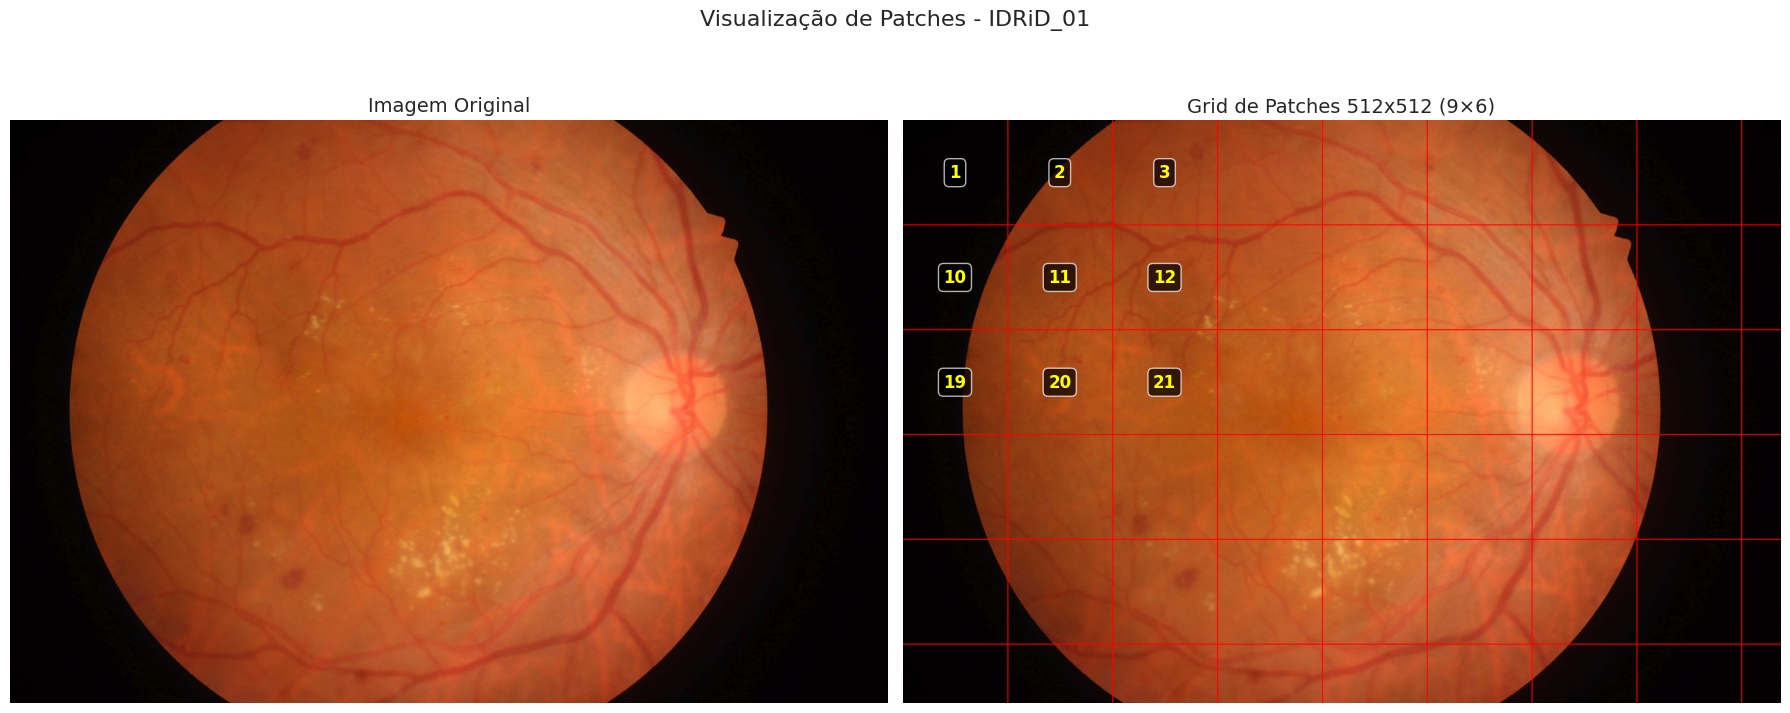


✓ Grid aplicado com sucesso!
  • Linhas vermelhas marcam as divisões dos patches
  • Números amarelos indicam os primeiros patches (1-9)
  • Cada patch tem 512x512 pixels


In [25]:
# Visualizar uma imagem real com grid de patches 512x512
sample_idx = 0
img_path = train_df.iloc[sample_idx]['image_path']
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print(f"Imagem: {train_df.iloc[sample_idx]['image_name']}")
print(f"Dimensões: {image_rgb.shape[1]}x{image_rgb.shape[0]} (W x H)")

# Configuração do patch
patch_size = 512
img_height, img_width = image_rgb.shape[:2]
patches_w = int(np.ceil(img_width / patch_size))
patches_h = int(np.ceil(img_height / patch_size))

print(f"Grid de patches: {patches_w}x{patches_h} = {patches_w * patches_h} patches")

# Criar cópia da imagem para desenhar o grid
image_with_grid = image_rgb.copy()

# Desenhar linhas verticais
for i in range(1, patches_w):
    x = i * patch_size
    cv2.line(image_with_grid, (x, 0), (x, img_height), (255, 0, 0), 3)

# Desenhar linhas horizontais
for j in range(1, patches_h):
    y = j * patch_size
    cv2.line(image_with_grid, (0, y), (img_width, y), (255, 0, 0), 3)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Imagem original
axes[0].imshow(image_rgb)
axes[0].set_title('Imagem Original', fontsize=14)
axes[0].axis('off')

# Imagem com grid
axes[1].imshow(image_with_grid)
axes[1].set_title(f'Grid de Patches {patch_size}x{patch_size} ({patches_w}×{patches_h})', fontsize=14)
axes[1].axis('off')

# Adicionar informações sobre alguns patches
for i in range(min(3, patches_w)):
    for j in range(min(3, patches_h)):
        x_center = i * patch_size + patch_size // 2
        y_center = j * patch_size + patch_size // 2
        patch_num = j * patches_w + i + 1
        axes[1].text(x_center, y_center, str(patch_num), 
                    color='yellow', fontsize=12, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.suptitle(f'Visualização de Patches - {train_df.iloc[sample_idx]["image_name"]}', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Grid aplicado com sucesso!")
print(f"  • Linhas vermelhas marcam as divisões dos patches")
print(f"  • Números amarelos indicam os primeiros patches (1-9)")
print(f"  • Cada patch tem {patch_size}x{patch_size} pixels")

## 13. Verificação Detalhada dos Patches - Imagens e Máscaras

Vamos verificar que os patches estão sendo extraídos corretamente com suas respectivas máscaras.

In [26]:
# Criar dataset de patches
from data_factory.ROP_dataset_patches import ROPDatasetPatches

PATCH_SIZE = 512
OVERLAP = 50

# Usar apenas uma imagem para teste
test_one_df = train_df.head(1)

patch_dataset = ROPDatasetPatches(
    dataframe=test_one_df,
    config=config,
    patch_size=PATCH_SIZE,
    overlap=OVERLAP,
    is_train=False  # Sem augmentation para ver dados originais
)

print(f"Dataset criado com {len(patch_dataset)} patches")
print(f"Imagem: {test_one_df.iloc[0]['image_name']}")

# Pegar o primeiro patch para inspeção detalhada
sample = patch_dataset[0]

print(f"\n=== Informações do Patch 0 ===")
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")
print(f"Image dtype: {sample['image'].dtype}")
print(f"Mask dtype: {sample['mask'].dtype}")
print(f"\nPosição do patch: ({sample['patch_x']}, {sample['patch_y']})")
print(f"Grid position: ({sample['grid_i']}, {sample['grid_j']})")
print(f"Dimensões originais: {sample['img_width']}x{sample['img_height']}")

Dataset criado com 70 patches
Imagem: IDRiD_01

=== Informações do Patch 0 ===
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512])
Image dtype: torch.float32
Mask dtype: torch.float32

Posição do patch: (0, 0)
Grid position: (0, 0)
Dimensões originais: 4288x2848


In [27]:
# Analisar valores dos pixels - Patch
image_patch = sample['image']
mask_patch = sample['mask']

print("=== Análise de Valores dos Pixels (Patch) ===\n")

# Imagem (normalizada pelo transform)
print("IMAGEM (normalizada):")
print(f"  Shape: {image_patch.shape}")
print(f"  Min: {image_patch.min():.4f}")
print(f"  Max: {image_patch.max():.4f}")
print(f"  Mean: {image_patch.mean():.4f}")
print(f"  Std: {image_patch.std():.4f}")
print(f"  Dtype: {image_patch.dtype}")

# Máscara
print(f"\nMÁSCARA:")
print(f"  Shape: {mask_patch.shape}")
print(f"  Classes: {len(config.classes)} ({', '.join(config.classes)})")

for idx, class_name in enumerate(config.classes):
    mask_class = mask_patch[idx]
    print(f"\n  Classe {idx} ({class_name}):")
    print(f"    Min: {mask_class.min():.4f}")
    print(f"    Max: {mask_class.max():.4f}")
    print(f"    Mean: {mask_class.mean():.4f}")
    print(f"    Valores únicos: {torch.unique(mask_class).tolist()}")
    print(f"    Pixels positivos: {(mask_class > 0.5).sum().item()} / {mask_class.numel()}")
    print(f"    Porcentagem positiva: {100 * (mask_class > 0.5).sum().item() / mask_class.numel():.2f}%")

=== Análise de Valores dos Pixels (Patch) ===

IMAGEM (normalizada):
  Shape: torch.Size([3, 512, 512])
  Min: -2.0837
  Max: -1.4210
  Mean: -1.8287
  Std: 0.1282
  Dtype: torch.float32

MÁSCARA:
  Shape: torch.Size([2, 512, 512])
  Classes: 2 (exudates, haemorrhages)

  Classe 0 (exudates):
    Min: 0.0000
    Max: 0.0000
    Mean: 0.0000
    Valores únicos: [0.0]
    Pixels positivos: 0 / 262144
    Porcentagem positiva: 0.00%

  Classe 1 (haemorrhages):
    Min: 0.0000
    Max: 0.0000
    Mean: 0.0000
    Valores únicos: [0.0]
    Pixels positivos: 0 / 262144
    Porcentagem positiva: 0.00%


In [28]:
# Carregar imagem original completa para comparação
img_path = test_one_df.iloc[0]['image_path']
img_original = cv2.imread(img_path)
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Carregar máscaras originais
mask_paths = test_one_df.iloc[0]['mask_exudates_paths']
mask_original_exudates = None
if isinstance(mask_paths, list) and len(mask_paths) > 0:
    mask_original_exudates = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

mask_paths = test_one_df.iloc[0]['mask_haemorrhages_paths']
mask_original_haemorrhages = None
if isinstance(mask_paths, list) and len(mask_paths) > 0:
    mask_original_haemorrhages = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

print("=== Análise de Valores dos Pixels (Imagem Original) ===\n")

print("IMAGEM ORIGINAL:")
print(f"  Shape: {img_original_rgb.shape}")
print(f"  Min: {img_original_rgb.min()}")
print(f"  Max: {img_original_rgb.max()}")
print(f"  Mean: {img_original_rgb.mean():.2f}")
print(f"  Dtype: {img_original_rgb.dtype}")

if mask_original_exudates is not None:
    print(f"\nMÁSCARA ORIGINAL - Exudates:")
    print(f"  Shape: {mask_original_exudates.shape}")
    print(f"  Min: {mask_original_exudates.min()}")
    print(f"  Max: {mask_original_exudates.max()}")
    print(f"  Valores únicos: {np.unique(mask_original_exudates)}")
    print(f"  Pixels positivos: {(mask_original_exudates > 0).sum()} / {mask_original_exudates.size}")
    print(f"  Porcentagem: {100 * (mask_original_exudates > 0).sum() / mask_original_exudates.size:.2f}%")
else:
    print("\nMÁSCARA ORIGINAL - Exudates: SEM MÁSCARA")

if mask_original_haemorrhages is not None:
    print(f"\nMÁSCARA ORIGINAL - Haemorrhages:")
    print(f"  Shape: {mask_original_haemorrhages.shape}")
    print(f"  Min: {mask_original_haemorrhages.min()}")
    print(f"  Max: {mask_original_haemorrhages.max()}")
    print(f"  Valores únicos: {np.unique(mask_original_haemorrhages)}")
    print(f"  Pixels positivos: {(mask_original_haemorrhages > 0).sum()} / {mask_original_haemorrhages.size}")
    print(f"  Porcentagem: {100 * (mask_original_haemorrhages > 0).sum() / mask_original_haemorrhages.size:.2f}%")
else:
    print("\nMÁSCARA ORIGINAL - Haemorrhages: SEM MÁSCARA")

=== Análise de Valores dos Pixels (Imagem Original) ===

IMAGEM ORIGINAL:
  Shape: (2848, 4288, 3)
  Min: 0
  Max: 255
  Mean: 73.62
  Dtype: uint8

MÁSCARA ORIGINAL - Exudates:
  Shape: (2848, 4288)
  Min: 0
  Max: 76
  Valores únicos: [ 0 76]
  Pixels positivos: 113286 / 12212224
  Porcentagem: 0.93%

MÁSCARA ORIGINAL - Haemorrhages:
  Shape: (2848, 4288)
  Min: 0
  Max: 76
  Valores únicos: [ 0 76]
  Pixels positivos: 35430 / 12212224
  Porcentagem: 0.29%


In [29]:
# Extrair o patch correspondente da imagem original para comparação
x, y = sample['patch_x'], sample['patch_y']
patch_from_original = img_original_rgb[y:y+PATCH_SIZE, x:x+PATCH_SIZE].copy()

# Extrair máscaras originais na posição do patch
if mask_original_exudates is not None:
    mask_patch_exudates_original = mask_original_exudates[y:y+PATCH_SIZE, x:x+PATCH_SIZE].copy()
else:
    mask_patch_exudates_original = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)

if mask_original_haemorrhages is not None:
    mask_patch_haemorrhages_original = mask_original_haemorrhages[y:y+PATCH_SIZE, x:x+PATCH_SIZE].copy()
else:
    mask_patch_haemorrhages_original = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)

print(f"=== Patch extraído da posição ({x}, {y}) ===\n")

print("PATCH da imagem original (antes do processamento):")
print(f"  Shape: {patch_from_original.shape}")
print(f"  Min: {patch_from_original.min()}")
print(f"  Max: {patch_from_original.max()}")
print(f"  Mean: {patch_from_original.mean():.2f}")
print(f"  Dtype: {patch_from_original.dtype}")

print(f"\nMÁSCARA do patch - Exudates (original):")
print(f"  Shape: {mask_patch_exudates_original.shape}")
print(f"  Min: {mask_patch_exudates_original.min()}")
print(f"  Max: {mask_patch_exudates_original.max()}")
print(f"  Valores únicos: {np.unique(mask_patch_exudates_original)}")
print(f"  Pixels positivos: {(mask_patch_exudates_original > 0).sum()}")

print(f"\nMÁSCARA do patch - Haemorrhages (original):")
print(f"  Shape: {mask_patch_haemorrhages_original.shape}")
print(f"  Min: {mask_patch_haemorrhages_original.min()}")
print(f"  Max: {mask_patch_haemorrhages_original.max()}")
print(f"  Valores únicos: {np.unique(mask_patch_haemorrhages_original)}")
print(f"  Pixels positivos: {(mask_patch_haemorrhages_original > 0).sum()}")

=== Patch extraído da posição (0, 0) ===

PATCH da imagem original (antes do processamento):
  Shape: (512, 512, 3)
  Min: 0
  Max: 12
  Mean: 2.51
  Dtype: uint8

MÁSCARA do patch - Exudates (original):
  Shape: (512, 512)
  Min: 0
  Max: 0
  Valores únicos: [0]
  Pixels positivos: 0

MÁSCARA do patch - Haemorrhages (original):
  Shape: (512, 512)
  Min: 0
  Max: 0
  Valores únicos: [0]
  Pixels positivos: 0


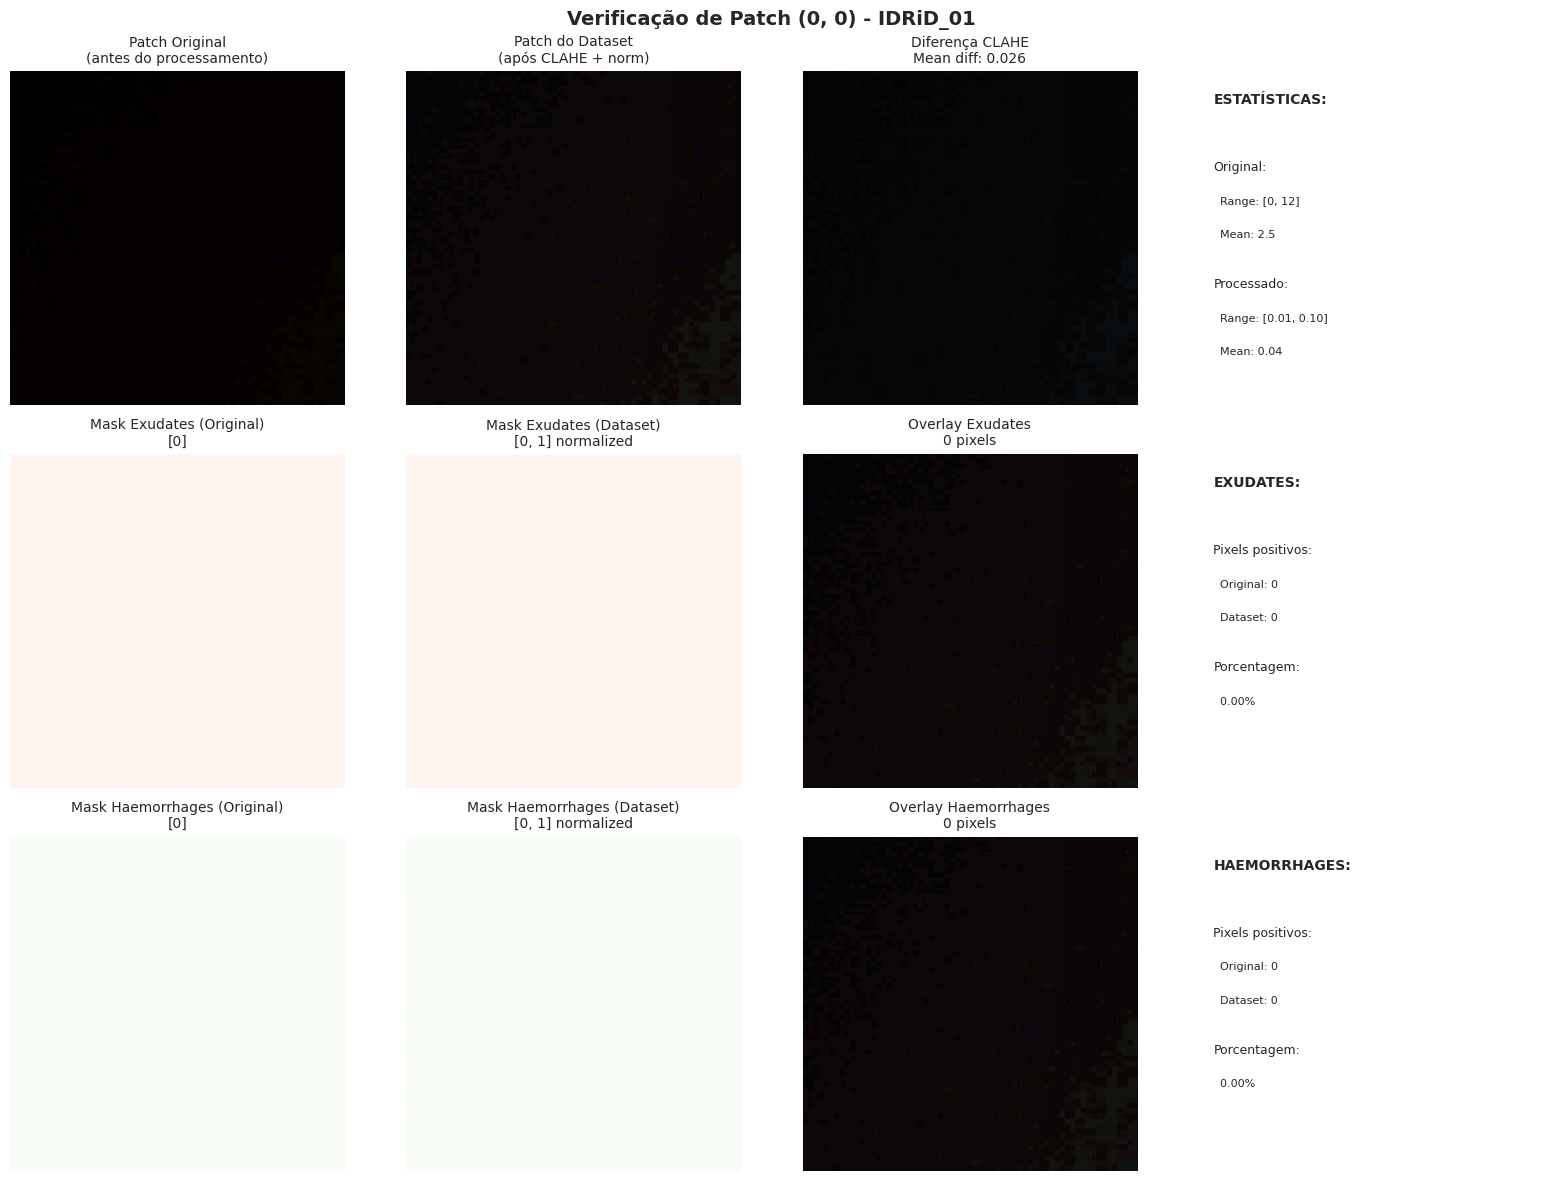


✓ Visualização completa!


In [33]:
# Visualização comparativa: Original vs Patch processado
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Denormalizar o patch do dataset para visualização
patch_denorm = sample['image'].permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
patch_denorm = patch_denorm * std + mean
patch_denorm = np.clip(patch_denorm, 0, 1)

# Converter máscaras do tensor para numpy
mask_exudates = sample['mask'][0].numpy()
mask_haemorrhages = sample['mask'][1].numpy()

# Linha 1: Imagens
# Normalizar patch original para [0, 1] para visualização
patch_from_original_norm = patch_from_original.astype(float) / 255.0

axes[0, 0].imshow(patch_from_original_norm)
axes[0, 0].set_title('Patch Original\n(antes do processamento)', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(patch_denorm)
axes[0, 1].set_title('Patch do Dataset\n(após CLAHE + norm)', fontsize=10)
axes[0, 1].axis('off')

# Diferença
diff = np.abs(patch_from_original_norm - patch_denorm)
axes[0, 2].imshow(diff)
axes[0, 2].set_title(f'Diferença CLAHE\nMean diff: {diff.mean():.3f}', fontsize=10)
axes[0, 2].axis('off')

# Stats
axes[0, 3].text(0.1, 0.9, 'ESTATÍSTICAS:', fontsize=10, fontweight='bold', transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.7, f'Original:', fontsize=9, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.6, f'  Range: [{patch_from_original.min()}, {patch_from_original.max()}]', 
                fontsize=8, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.5, f'  Mean: {patch_from_original.mean():.1f}', fontsize=8, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.35, f'Processado:', fontsize=9, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.25, f'  Range: [{patch_denorm.min():.2f}, {patch_denorm.max():.2f}]', 
                fontsize=8, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.15, f'  Mean: {patch_denorm.mean():.2f}', fontsize=8, transform=axes[0, 3].transAxes)
axes[0, 3].axis('off')

# Linha 2: Máscaras Exudates
axes[1, 0].imshow(mask_patch_exudates_original, cmap='Reds', vmin=0, vmax=255)
axes[1, 0].set_title(f'Mask Exudates (Original)\n{np.unique(mask_patch_exudates_original)}', fontsize=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_exudates, cmap='Reds', vmin=0, vmax=1)
axes[1, 1].set_title(f'Mask Exudates (Dataset)\n[0, 1] normalized', fontsize=10)
axes[1, 1].axis('off')

# Overlay exudates
overlay_exudates = patch_denorm.copy()
overlay_exudates[mask_exudates > 0.5] = [1, 0, 0]
axes[1, 2].imshow(overlay_exudates)
axes[1, 2].set_title(f'Overlay Exudates\n{(mask_exudates > 0.5).sum()} pixels', fontsize=10)
axes[1, 2].axis('off')

# Stats exudates
axes[1, 3].text(0.1, 0.9, 'EXUDATES:', fontsize=10, fontweight='bold', transform=axes[1, 3].transAxes)
axes[1, 3].text(0.1, 0.7, f'Pixels positivos:', fontsize=9, transform=axes[1, 3].transAxes)
axes[1, 3].text(0.1, 0.6, f'  Original: {(mask_patch_exudates_original > 0).sum()}', 
                fontsize=8, transform=axes[1, 3].transAxes)
axes[1, 3].text(0.1, 0.5, f'  Dataset: {(mask_exudates > 0.5).sum()}', 
                fontsize=8, transform=axes[1, 3].transAxes)
axes[1, 3].text(0.1, 0.35, f'Porcentagem:', fontsize=9, transform=axes[1, 3].transAxes)
axes[1, 3].text(0.1, 0.25, f'  {100 * (mask_exudates > 0.5).sum() / mask_exudates.size:.2f}%', 
                fontsize=8, transform=axes[1, 3].transAxes)
axes[1, 3].axis('off')

# Linha 3: Máscaras Haemorrhages
axes[2, 0].imshow(mask_patch_haemorrhages_original, cmap='Greens', vmin=0, vmax=255)
axes[2, 0].set_title(f'Mask Haemorrhages (Original)\n{np.unique(mask_patch_haemorrhages_original)}', fontsize=10)
axes[2, 0].axis('off')

axes[2, 1].imshow(mask_haemorrhages, cmap='Greens', vmin=0, vmax=1)
axes[2, 1].set_title(f'Mask Haemorrhages (Dataset)\n[0, 1] normalized', fontsize=10)
axes[2, 1].axis('off')

# Overlay haemorrhages
overlay_haemorrhages = patch_denorm.copy()
overlay_haemorrhages[mask_haemorrhages > 0.5] = [0, 1, 0]
axes[2, 2].imshow(overlay_haemorrhages)
axes[2, 2].set_title(f'Overlay Haemorrhages\n{(mask_haemorrhages > 0.5).sum()} pixels', fontsize=10)
axes[2, 2].axis('off')

# Stats haemorrhages
axes[2, 3].text(0.1, 0.9, 'HAEMORRHAGES:', fontsize=10, fontweight='bold', transform=axes[2, 3].transAxes)
axes[2, 3].text(0.1, 0.7, f'Pixels positivos:', fontsize=9, transform=axes[2, 3].transAxes)
axes[2, 3].text(0.1, 0.6, f'  Original: {(mask_patch_haemorrhages_original > 0).sum()}', 
                fontsize=8, transform=axes[2, 3].transAxes)
axes[2, 3].text(0.1, 0.5, f'  Dataset: {(mask_haemorrhages > 0.5).sum()}', 
                fontsize=8, transform=axes[2, 3].transAxes)
axes[2, 3].text(0.1, 0.35, f'Porcentagem:', fontsize=9, transform=axes[2, 3].transAxes)
axes[2, 3].text(0.1, 0.25, f'  {100 * (mask_haemorrhages > 0.5).sum() / mask_haemorrhages.size:.2f}%', 
                fontsize=8, transform=axes[2, 3].transAxes)
axes[2, 3].axis('off')

plt.suptitle(f'Verificação de Patch {sample["patch_x"], sample["patch_y"]} - {sample["image_name"]}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Visualização completa!")

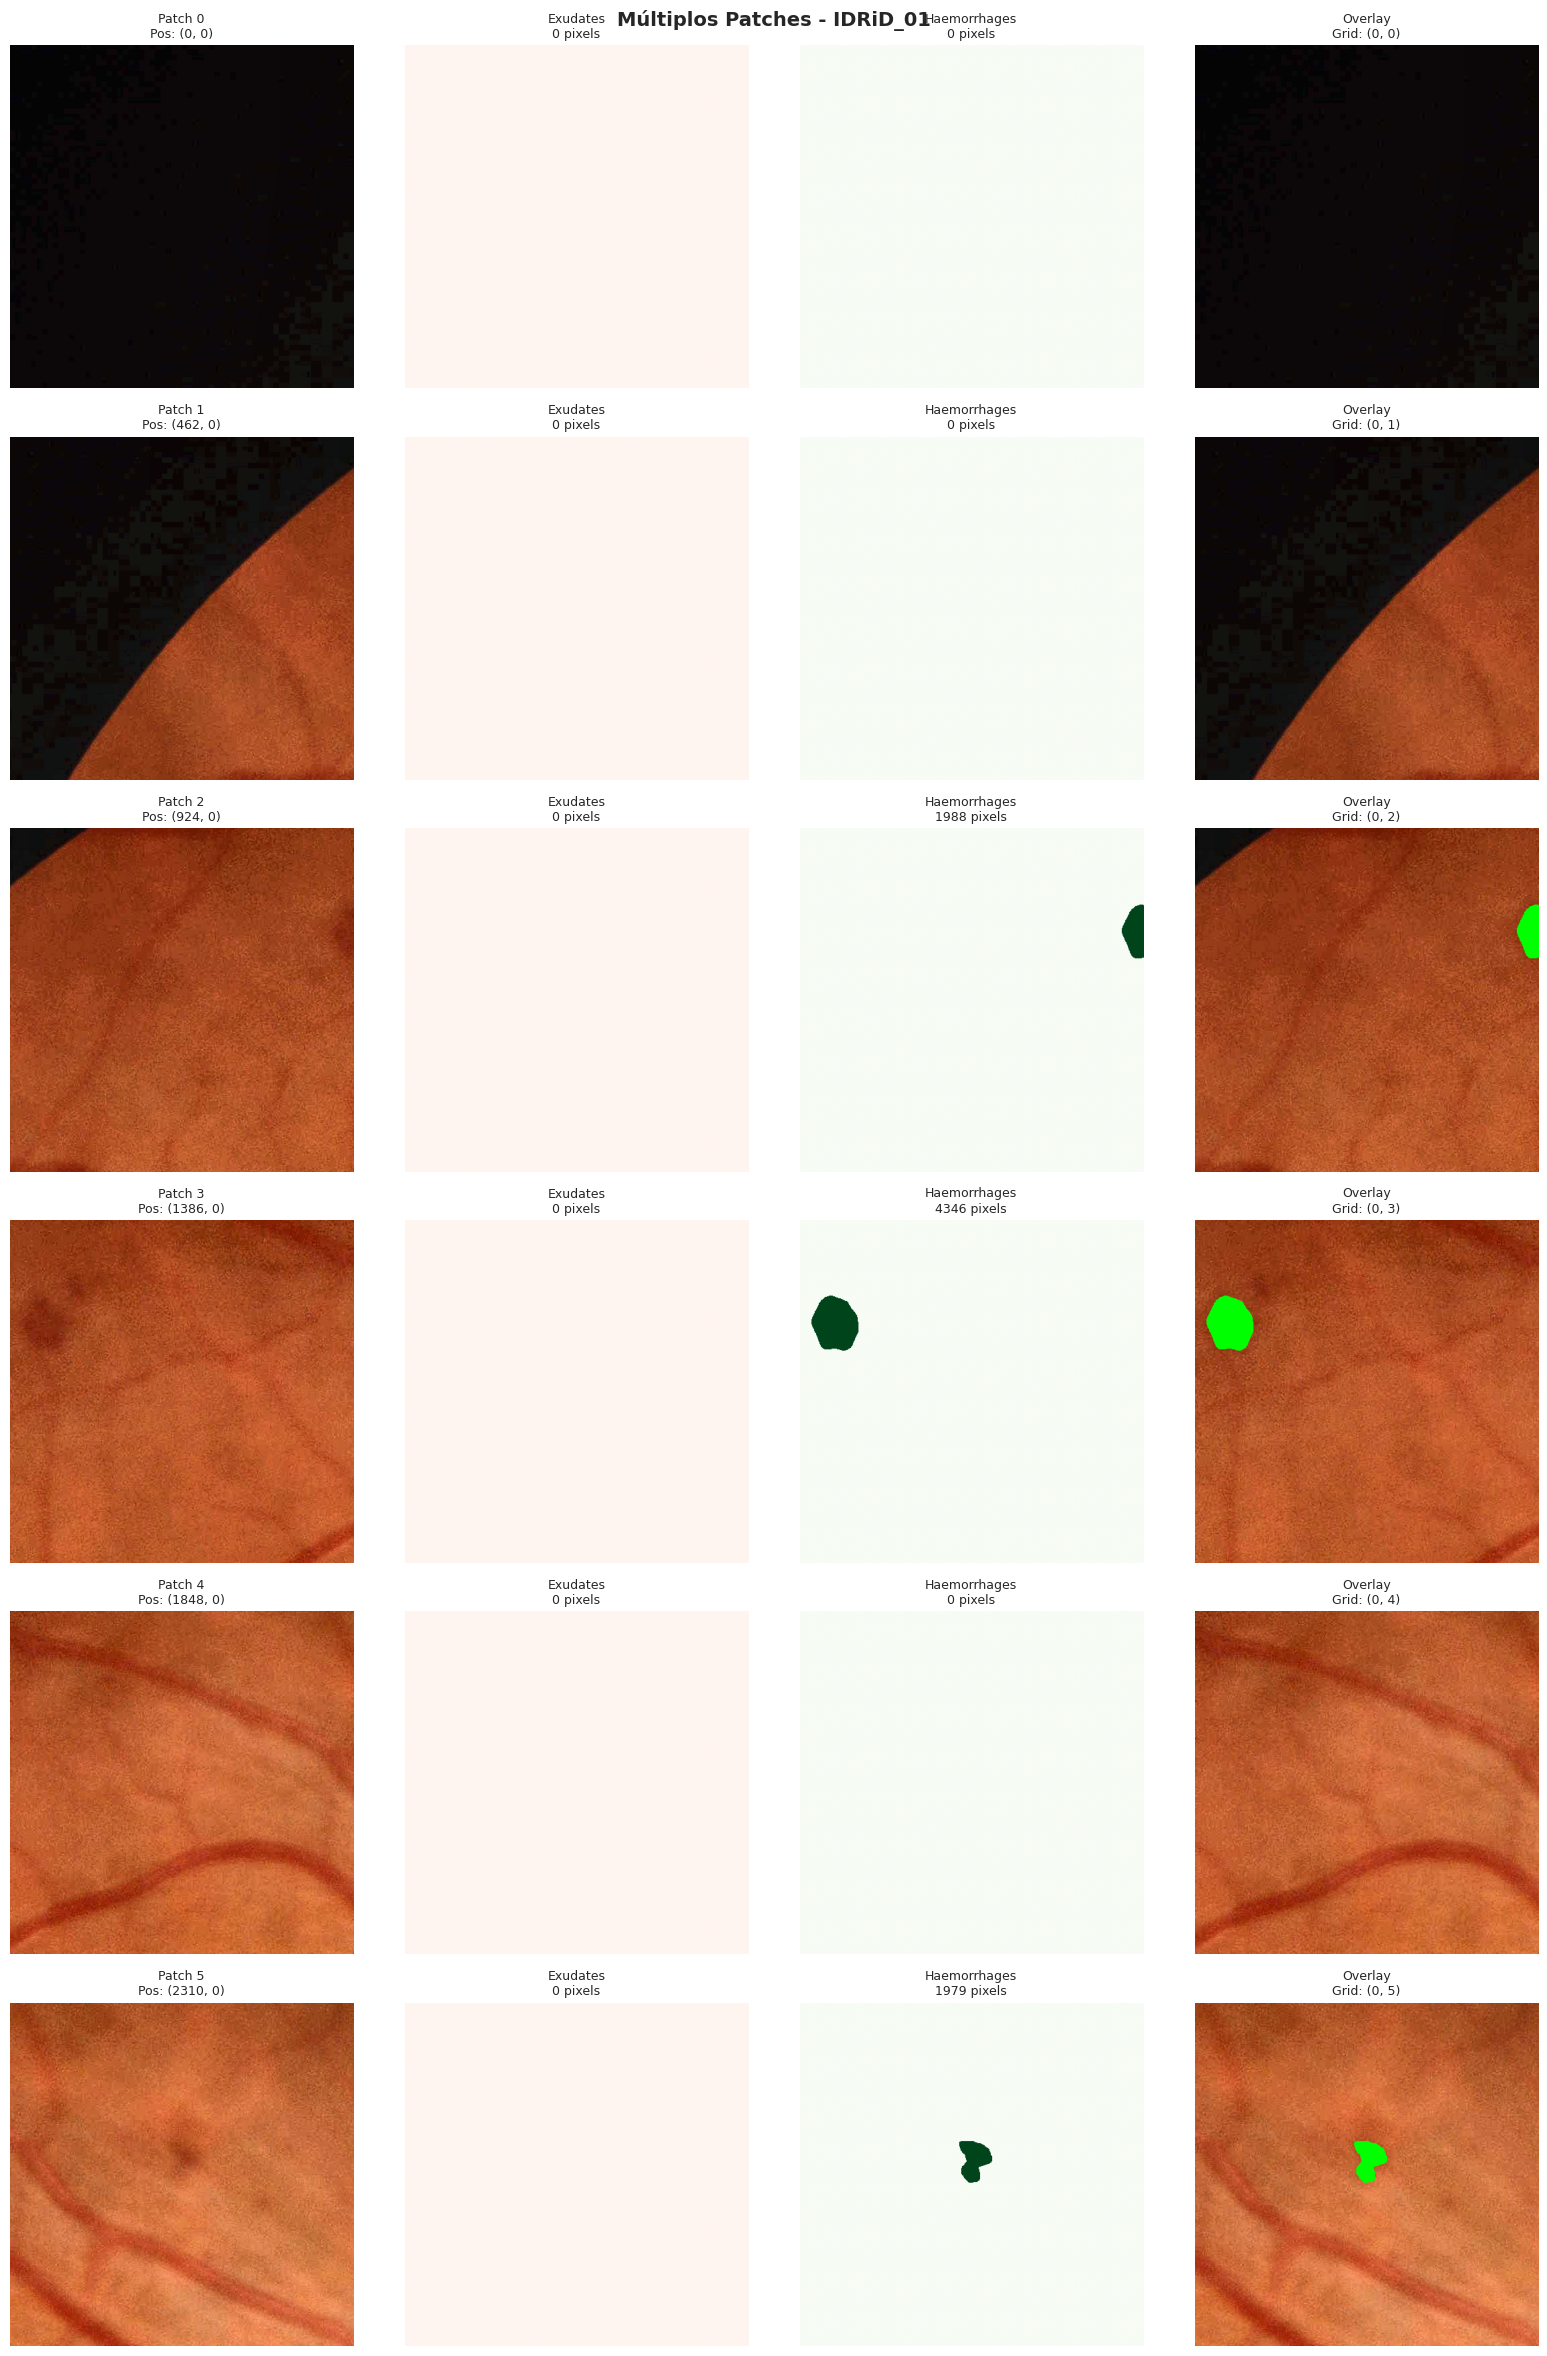


✓ Visualização de 6 patches concluída!


In [34]:
# Visualizar vários patches da mesma imagem
n_patches_to_show = min(6, len(patch_dataset))
fig, axes = plt.subplots(n_patches_to_show, 4, figsize=(16, 4*n_patches_to_show))

for i in range(n_patches_to_show):
    sample = patch_dataset[i]
    
    # Denormalizar imagem
    patch_img = sample['image'].permute(1, 2, 0).numpy()
    patch_img = patch_img * std + mean
    patch_img = np.clip(patch_img, 0, 1)
    
    # Máscaras
    mask_exu = sample['mask'][0].numpy()
    mask_hae = sample['mask'][1].numpy()
    
    # Imagem
    axes[i, 0].imshow(patch_img)
    axes[i, 0].set_title(f'Patch {i}\nPos: ({sample["patch_x"]}, {sample["patch_y"]})', fontsize=9)
    axes[i, 0].axis('off')
    
    # Máscara Exudates
    axes[i, 1].imshow(mask_exu, cmap='Reds', vmin=0, vmax=1)
    axes[i, 1].set_title(f'Exudates\n{(mask_exu > 0.5).sum()} pixels', fontsize=9)
    axes[i, 1].axis('off')
    
    # Máscara Haemorrhages
    axes[i, 2].imshow(mask_hae, cmap='Greens', vmin=0, vmax=1)
    axes[i, 2].set_title(f'Haemorrhages\n{(mask_hae > 0.5).sum()} pixels', fontsize=9)
    axes[i, 2].axis('off')
    
    # Overlay combinado
    overlay = patch_img.copy()
    overlay[mask_exu > 0.5] = [1, 0, 0]
    overlay[mask_hae > 0.5] = [0, 1, 0]
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f'Overlay\nGrid: ({sample["grid_i"]}, {sample["grid_j"]})', fontsize=9)
    axes[i, 3].axis('off')

plt.suptitle(f'Múltiplos Patches - {sample["image_name"]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Visualização de {n_patches_to_show} patches concluída!")

In [35]:
# Resumo final da verificação
print("="*80)
print("RESUMO DA VERIFICAÇÃO DE PATCHES")
print("="*80)

print(f"\n✓ Dataset de patches criado com sucesso")
print(f"  • Total de patches: {len(patch_dataset)}")
print(f"  • Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"  • Overlap: {OVERLAP}px")
print(f"  • Stride: {PATCH_SIZE - OVERLAP}px")

print(f"\n✓ Dimensões verificadas:")
print(f"  • Imagem: {sample['image'].shape} (C, H, W)")
print(f"  • Máscara: {sample['mask'].shape} (Classes, H, W)")

print(f"\n✓ Ranges de valores:")
print(f"  • Imagem normalizada: [{sample['image'].min():.2f}, {sample['image'].max():.2f}]")
print(f"  • Máscaras: [0.0, 1.0]")

print(f"\n✓ Processamento aplicado:")
print(f"  • CLAHE no canal L (LAB color space)")
print(f"  • Normalização ImageNet (mean/std)")
print(f"  • Máscaras binarizadas [0, 1]")

print(f"\n✓ Alinhamento espacial:")
print(f"  • Patches e máscaras extraídos da mesma posição")
print(f"  • Dimensões consistentes")
print(f"  • Overlap preserva contexto")

print("\n" + "="*80)
print("✅ TUDO VERIFICADO E FUNCIONANDO CORRETAMENTE!")
print("="*80)

RESUMO DA VERIFICAÇÃO DE PATCHES

✓ Dataset de patches criado com sucesso
  • Total de patches: 70
  • Patch size: 512x512
  • Overlap: 50px
  • Stride: 462px

✓ Dimensões verificadas:
  • Imagem: torch.Size([3, 512, 512]) (C, H, W)
  • Máscara: torch.Size([2, 512, 512]) (Classes, H, W)

✓ Ranges de valores:
  • Imagem normalizada: [-1.80, 2.25]
  • Máscaras: [0.0, 1.0]

✓ Processamento aplicado:
  • CLAHE no canal L (LAB color space)
  • Normalização ImageNet (mean/std)
  • Máscaras binarizadas [0, 1]

✓ Alinhamento espacial:
  • Patches e máscaras extraídos da mesma posição
  • Dimensões consistentes
  • Overlap preserva contexto

✅ TUDO VERIFICADO E FUNCIONANDO CORRETAMENTE!


## 10. Análise de Distribuição Train/Test por Paciente

## 9. Visualizar Efeito do Pré-processamento CLAHE

## 8. Análise de Propriedades das Imagens

## 7. Visualizar Amostras com Hemorragias

## 6. Visualizar Amostras com Exudatos

## 5. Visualizar Exemplos de Imagens - Training Set

## 4. Análise da Distribuição das Classes

## 3. Criar DataFrames de Metadados

## 2. Carregar Configurações e Criar DataFactory

## 1. Importar Bibliotecas